In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from scipy.stats import pearsonr, spearmanr

import prepare

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# utilized for creating models and visualization
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# utilized for metrics on my models
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

# What should my target variable be?

- I feel as though attrition should be my target variable because it would be important to the company to predict when and why employees are leaving their place of business.

- Questions to be asked:

> Does personal features such as performance rating, number of companies worked, age, marital status, etc have a large influence on attrition?
>
> Does company involvement such as pay, manager rotation, environment, etc have a large influence on attrition?
>
> Which employees with specific educational backgrounds leave and which ones stay?
>
> Which job roles are more prone to have high turnover? Which ones incur high tenure? 
>
> What is the attrition rate of eople who have most of their work experience at the company?

---------------------------------------------------------------

# Goals and Deliverables

- My goal is to create the best model for predicting the attrition rate of employees at this company.

- I aim to deliver a working model along with an entire notebook outlining how I came to my conclusion and end product.

------

# Initial Thoughts and Hypotheses

> My thought process going into this project is that the individauls who have a weaker incentive to stay monetarily are the ones who incur higher turnover.

------

# Acquire and Prepare

In [39]:
# pulling and cleaning dataframe
df = prepare.pull_csv()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   age                      1470 non-null   int64 
 1   attrition                1470 non-null   int64 
 2   department               1470 non-null   int64 
 3   educationfield           1470 non-null   int64 
 4   environmentsatisfaction  1470 non-null   int64 
 5   gender                   1470 non-null   object
 6   joblevel                 1470 non-null   int64 
 7   maritalstatus            1470 non-null   int64 
 8   monthlyincome            1470 non-null   int64 
 9   numcompaniesworked       1470 non-null   int64 
 10  percentsalaryhike        1470 non-null   int64 
 11  performancerating        1470 non-null   int64 
 12  stockoptionlevel         1470 non-null   int64 
 13  totalworkingyears        1470 non-null   int64 
 14  trainingtimeslastyear    1470 non-null  

## There were no nulls and I reduced the amount of columns down to 16 relevant features during my initial exploration

In [3]:
# splitting the dataframe for exploration
train, validate, test = prepare.my_train_test_split(df, 'attrition')
train.shape, validate.shape, test.shape

((882, 17), (294, 17), (294, 17))

------

# Explore

<AxesSubplot:>

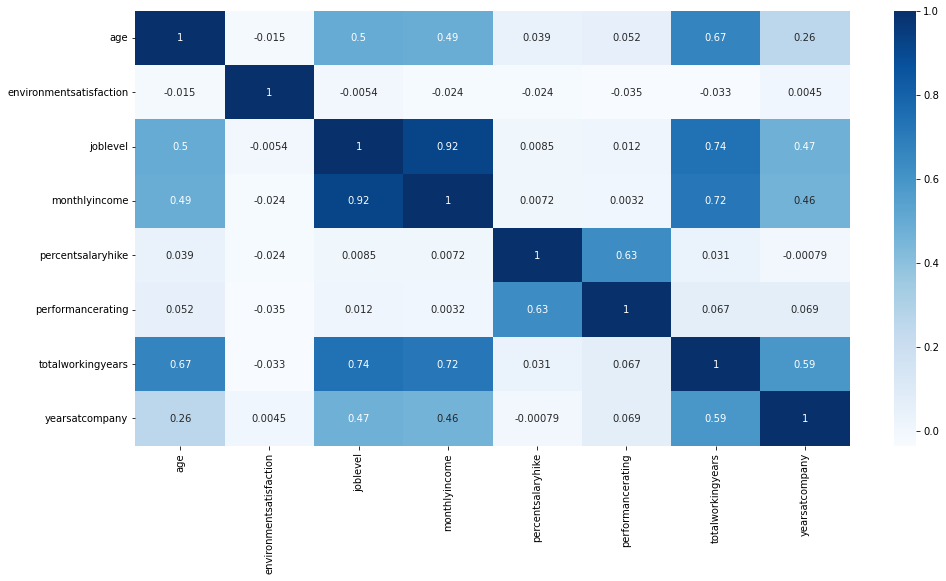

In [4]:
# separating numerical columns from the categorical columns
num_list, cat_list = prepare.dtypes_to_list(train)

# creating a heatmap to see the correlation betweeen all of the numerical columns/features
hr_corr = train[num_list].corr(method='spearman')

plt.figure(figsize=(16,8))
sns.heatmap(hr_corr, cmap='Blues', annot=True)

### At first look we can see a decent correlation between total working years and age, total working years and job level, total working years and monthly income, performance rating and percent salary hike, and the highest correlation aligns with monthly income and job level.

## Let's look at the relationship between some of the features and attrition

## Does the monetary features have a strong relationship with attrition?

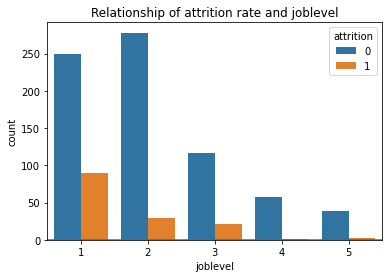

In [5]:
# creating a countplot for job level
prepare.hr_vis(train, 'joblevel')

In [6]:
# creating a chi square test for job level
prepare.hr_test(train, 'joblevel')

We reject the null hypothesis that joblevel and attrition rate are independent
There is a relationship between attrition rate and joblevel


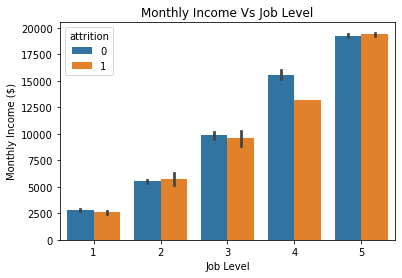

In [7]:
# visualizing the relationship between income and job level
sns.barplot(x = train.joblevel, y=train.monthlyincome, hue= 'attrition', data = train)
plt.title('Monthly Income Vs Job Level')
plt.xlabel('Job Level')
plt.ylabel('Monthly Income ($)')
plt.show()

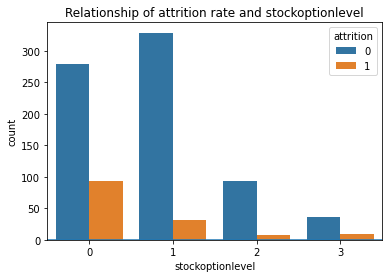

In [8]:
# creating a countplot for stock option levels
prepare.hr_vis(train, 'stockoptionlevel')

In [9]:
# creating a chi square test for stock option levels
prepare.hr_test(train, 'stockoptionlevel')

We reject the null hypothesis that stockoptionlevel and attrition rate are independent
There is a relationship between attrition rate and stockoptionlevel


## Employees making the least amount of money (junior positions) are more prone to leaving the company

## Does the field of education affect attrition rate?

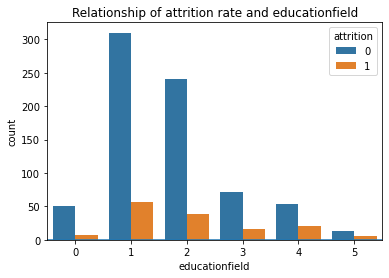

In [10]:
# creating a countplot for education fields of study
prepare.hr_vis(train, 'educationfield')

In [11]:
# creating a chi square test for education fields of study
prepare.hr_test(train, 'educationfield')

We fail to reject the null hypothesis that educationfield and attrition rate are independent
There appears to be no relationship between attrition rate and educationfield


## At first glance it seems that one's field of education influences whether they will stay or not, but futher testing proves that education is independent of attrition.

## Since junior level employees tend to be targets of attrition, then does that mean total work experience affects attrition rate?

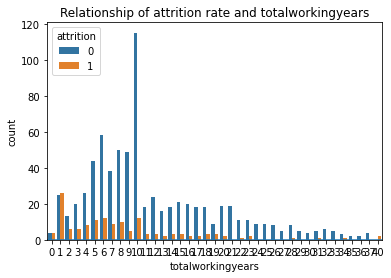

In [12]:
# creating a countplot for total years of experience in the workforce
prepare.hr_vis(train, 'totalworkingyears')

In [13]:
# creating a chi square test for total years of experience in the workforce
prepare.hr_test(train, 'totalworkingyears')

We reject the null hypothesis that totalworkingyears and attrition rate are independent
There is a relationship between attrition rate and totalworkingyears


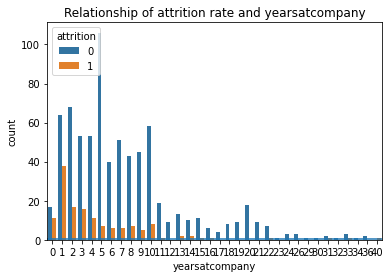

In [14]:
# creating a countplot for years worked at the company
prepare.hr_vis(train, 'yearsatcompany')

In [15]:
# creating a chi square test for years worked at the company
prepare.hr_test(train, 'yearsatcompany')

We reject the null hypothesis that yearsatcompany and attrition rate are independent
There is a relationship between attrition rate and yearsatcompany


## Employees within their first year of joining the work force as a whole tend to leave the company more often than others thus making it also true that employees who have the least amount of tenure at mystery company will influence the attrition rate

## Exploration Summary

> Overall within my deep dive exploration (further exploration not outlined in this final version) I discovered that many features were not as influential as others were thus not a large contributing factor for modeling.  The main target groups appear to be younger employees who have entered the workforce for the first time and the mystery company is their first company.  Those who are paid at a junior level are also a major focus for modeling.

----------

# Modeling 

In [16]:
# creating the baseline predictions
X_train, X_validate, X_test, y_train, y_validate, y_test = prepare.model_prep(train, validate, test)

The baseline accuracy for retained employees in all cases within the hr_analytics dataset is 0.84


## Decision Tree Model

In [17]:
# creating a for loop to generate classifcation reports for various Decision Tree Models using the train data
for i in range (5, 16, 5):
    clf = DecisionTreeClassifier(max_depth= i, random_state=123)
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_train)
    print(f'Tree with max depth of {i}')
    print(pd.DataFrame(classification_report(y_train, y_pred, output_dict=True)))

Tree with max depth of 5
                    0           1  accuracy   macro avg  weighted avg
precision    0.892593    0.777778   0.88322    0.835185      0.873977
recall       0.978349    0.391608   0.88322    0.684979      0.883220
f1-score     0.933505    0.520930   0.88322    0.727218      0.866614
support    739.000000  143.000000   0.88322  882.000000    882.000000
Tree with max depth of 10
                    0           1  accuracy   macro avg  weighted avg
precision    0.969777    0.991736  0.972789    0.980756      0.973337
recall       0.998647    0.839161  0.972789    0.918904      0.972789
f1-score     0.984000    0.909091  0.972789    0.946545      0.971855
support    739.000000  143.000000  0.972789  882.000000    882.000000
Tree with max depth of 15
                    0           1  accuracy   macro avg  weighted avg
precision    0.998647    0.993007  0.997732    0.995827      0.997732
recall       0.998647    0.993007  0.997732    0.995827      0.997732
f1-score     

In [18]:
# creating a for loop to generate classifcation reports for various Decision Tree Models using the validate data
# to test for overfitting
for i in range (5, 16, 5):
    clf = DecisionTreeClassifier(max_depth= i, random_state=123)
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_validate)
    print(f'Tree with max depth of {i}')
    print(pd.DataFrame(classification_report(y_validate, y_pred, output_dict=True)))

Tree with max depth of 5
                    0          1  accuracy   macro avg  weighted avg
precision    0.853047   0.400000  0.829932    0.626523      0.780621
recall       0.963563   0.127660  0.829932    0.545611      0.829932
f1-score     0.904943   0.193548  0.829932    0.549246      0.791217
support    247.000000  47.000000  0.829932  294.000000    294.000000
Tree with max depth of 10
                    0          1  accuracy   macro avg  weighted avg
precision    0.864000   0.295455  0.778912    0.579727      0.773110
recall       0.874494   0.276596  0.778912    0.575545      0.778912
f1-score     0.869215   0.285714  0.778912    0.577465      0.775935
support    247.000000  47.000000  0.778912  294.000000    294.000000
Tree with max depth of 15
                    0          1  accuracy   macro avg  weighted avg
precision    0.865306   0.285714  0.768707    0.575510      0.772650
recall       0.858300   0.297872  0.768707    0.578086      0.768707
f1-score     0.861789   0.

In [19]:
# After finding the best model using decision tree methodology I compared the train set's accuracy score with the 
# validate set's accuracy score to determine the level of consistency between trained data and untrained data.
clf = DecisionTreeClassifier(max_depth=5, random_state=123)
clf = clf.fit(X_train, y_train)
clf.score(X_train, y_train) - clf.score(X_validate, y_validate)

0.053287981859410416

### The Decision Tree Model has an 82% Accuracy which is worst than baseline

## Logistic Regression Model Creation

In [20]:
# Created a new model with a new C value of .1
logit = LogisticRegression(random_state=123, C=.1)
logit = logit.fit(X_train, y_train)
y_pred = logit.predict(X_train)
print(pd.DataFrame(classification_report(y_train, y_pred, output_dict=True)))
print()
print(pd.DataFrame(classification_report(y_validate, logit.predict(X_validate), output_dict=True)))

                    0           1  accuracy   macro avg  weighted avg
precision    0.839408    0.500000  0.837868    0.669704      0.784379
recall       0.997294    0.013986  0.837868    0.505640      0.837868
f1-score     0.911565    0.027211  0.837868    0.469388      0.768183
support    739.000000  143.000000  0.837868  882.000000    882.000000

                    0     1  accuracy   macro avg  weighted avg
precision    0.839590   0.0  0.836735    0.419795      0.705370
recall       0.995951   0.0  0.836735    0.497976      0.836735
f1-score     0.911111   0.0  0.836735    0.455556      0.765457
support    247.000000  47.0  0.836735  294.000000    294.000000


In [21]:
# Utilizing my established features within the X_train variable and my target with y_train, I created a logistic
# regression model to best predict churn rate.  
logit = LogisticRegression(random_state=123)
logit = logit.fit(X_train, y_train)
y_pred = logit.predict(X_train)
print(pd.DataFrame(classification_report(y_train, y_pred, output_dict=True)))
print()
print(pd.DataFrame(classification_report(y_validate, logit.predict(X_validate), output_dict=True)))

                    0           1  accuracy   macro avg  weighted avg
precision    0.840961    0.500000  0.837868    0.670481      0.785681
recall       0.994587    0.027972  0.837868    0.511280      0.837868
f1-score     0.911345    0.052980  0.837868    0.482163      0.772177
support    739.000000  143.000000  0.837868  882.000000    882.000000

                    0     1  accuracy   macro avg  weighted avg
precision    0.839041   0.0  0.833333    0.419521      0.704909
recall       0.991903   0.0  0.833333    0.495951      0.833333
f1-score     0.909091   0.0  0.833333    0.454545      0.763760
support    247.000000  47.0  0.833333  294.000000    294.000000


In [22]:
# After finding the best model using logitstic regression methodology I compared the train set's accuracy score 
# with the validate set's accuracy score to determine the level of consistency between trained data and untrained 
# data.
logit.score(X_validate, y_validate)-logit.score(X_train, y_train)

-0.0045351473922902175

### The best Logistic Regression Model performed worst than baseline just like the Decision Tree model with an 83% accuracy rating

## Random Forest Model Creation

In [23]:
# Creating multiple Random Forest models utilizing the same chosen features as previous models.  Created a for 
# loop that allows me to look at multiple max depths at once for the train dataset.
for i in range (5, 11):
    rf = RandomForestClassifier(max_depth= i, random_state=123)
    rf = rf.fit(X_train, y_train)
    y_pred = rf.predict(X_train)
    print(f'Tree with max depth of {i}')
    print(pd.DataFrame(classification_report(y_train, y_pred, output_dict=True)))

Tree with max depth of 5
                    0           1  accuracy   macro avg  weighted avg
precision    0.872038    0.921053   0.87415    0.896545      0.879985
recall       0.995940    0.244755   0.87415    0.620348      0.874150
f1-score     0.929880    0.386740   0.87415    0.658310      0.841820
support    739.000000  143.000000   0.87415  882.000000    882.000000
Tree with max depth of 6
                    0           1  accuracy   macro avg  weighted avg
precision    0.891173    0.963636  0.895692    0.927405      0.902922
recall       0.997294    0.370629  0.895692    0.683962      0.895692
f1-score     0.941252    0.535354  0.895692    0.738303      0.875443
support    739.000000  143.000000  0.895692  882.000000    882.000000
Tree with max depth of 7
                    0           1  accuracy   macro avg  weighted avg
precision    0.904412    0.984848  0.910431    0.944630      0.917453
recall       0.998647    0.454545  0.910431    0.726596      0.910431
f1-score     0.

In [24]:
# Created a for loop that allows me to look at multiple max depths at once for the validate dataset.
for i in range (5, 11):
    rf = RandomForestClassifier(max_depth= i, random_state=123)
    rf = rf.fit(X_train, y_train)
    y_pred = rf.predict(X_validate)
    print(f'Tree with max depth of {i}')
    print(pd.DataFrame(classification_report(y_validate, y_pred, output_dict=True)))

Tree with max depth of 5
                    0          1  accuracy   macro avg  weighted avg
precision    0.850694   0.666667  0.846939    0.758681      0.821275
recall       0.991903   0.085106  0.846939    0.538505      0.846939
f1-score     0.915888   0.150943  0.846939    0.533416      0.793601
support    247.000000  47.000000  0.846939  294.000000    294.000000
Tree with max depth of 6
                    0          1  accuracy   macro avg  weighted avg
precision    0.852632   0.555556  0.843537    0.704094      0.805140
recall       0.983806   0.106383  0.843537    0.545094      0.843537
f1-score     0.913534   0.178571  0.843537    0.546053      0.796040
support    247.000000  47.000000  0.843537  294.000000    294.000000
Tree with max depth of 7
                    0          1  accuracy   macro avg  weighted avg
precision    0.853147   0.625000  0.846939    0.739073      0.816674
recall       0.987854   0.106383  0.846939    0.547119      0.846939
f1-score     0.915572   0.18

## A max depth of 5 offered the best results in terms of accuracy and precision.

In [36]:
# After discovering that max depth of 5 was the best Random Forest model, I compared the train dataset's accuracy
# to that of the validate dataset's accuracy
rf = RandomForestClassifier(max_depth=5,random_state=123)
rf = rf.fit(X_train, y_train)
rf.score(X_train, y_train) - rf.score(X_validate, y_validate)

0.027210884353741416

## KNN Model Creation

In [26]:
for i in range (10, 31, 5):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn = knn.fit(X_train, y_train)
    y_pred = knn.predict(X_train)
    print(f'KNeighbors with n_neighbors of {i}')
    print(pd.DataFrame(classification_report(y_train, y_pred, output_dict=True)))

KNeighbors with n_neighbors of 10
                    0           1  accuracy   macro avg  weighted avg
precision    0.850000    0.636364  0.844671    0.743182      0.815363
recall       0.989175    0.097902  0.844671    0.543538      0.844671
f1-score     0.914321    0.169697  0.844671    0.542009      0.793594
support    739.000000  143.000000  0.844671  882.000000    882.000000
KNeighbors with n_neighbors of 15
                    0           1  accuracy   macro avg  weighted avg
precision    0.853946    0.575758  0.843537    0.714852      0.808843
recall       0.981055    0.132867  0.843537    0.556961      0.843537
f1-score     0.913098    0.215909  0.843537    0.564504      0.800062
support    739.000000  143.000000  0.843537  882.000000    882.000000
KNeighbors with n_neighbors of 20
                    0           1  accuracy   macro avg  weighted avg
precision    0.848204    0.631579  0.843537    0.739891      0.813082
recall       0.990528    0.083916  0.843537    0.537222   

In [27]:
for i in range (10, 31, 5):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn = knn.fit(X_train, y_train)
    y_pred = knn.predict(X_validate)
    print(f'KNeighbors with n_neighbors of {i}')
    print(pd.DataFrame(classification_report(y_validate, y_pred, output_dict=True)))

KNeighbors with n_neighbors of 10
                    0          1  accuracy   macro avg  weighted avg
precision    0.844291   0.400000  0.836735    0.622145      0.773265
recall       0.987854   0.042553  0.836735    0.515204      0.836735
f1-score     0.910448   0.076923  0.836735    0.493685      0.777197
support    247.000000  47.000000  0.836735  294.000000    294.000000
KNeighbors with n_neighbors of 15
                    0          1  accuracy   macro avg  weighted avg
precision    0.844828   0.500000  0.840136    0.672414      0.789702
recall       0.991903   0.042553  0.840136    0.517228      0.840136
f1-score     0.912477   0.078431  0.840136    0.495454      0.779143
support    247.000000  47.000000  0.840136  294.000000    294.000000
KNeighbors with n_neighbors of 20
                    0          1  accuracy   macro avg  weighted avg
precision    0.841924   0.333333  0.836735    0.587629      0.760619
recall       0.991903   0.021277  0.836735    0.506590      0.836735
f

In [28]:
knn = KNeighborsClassifier(n_neighbors=15)
knn = knn.fit(X_train, y_train)
knn.score(X_train, y_train) - knn.score(X_validate, y_validate)

0.003401360544217691

### The KNN Model was able to beat baseline but with a lower precision than the Random Forest Model

## MVP Model Creation Takeaways
- Decision Tree model max depth of 5 (.05 variation between train and val).  Did not beat baseline.
- Logistic Regression model c value of 1 (-.004 variation). Did not beat baseline.
- Random Forest model max depth of 5 (.03 variation). Best accuracy score and precision score.
- K-Nearest Neighbor model n_neighbors of 15 (.003 variation). Weak precision score.  Barely beat baseline.

- I discovered that the best model overall was that of the Random Forest model due to it having the best precision and even while still outperforming baseline even though it was a very low improvement from baseline.  Out of all of the models, Random Forest was able to predict attrition accurately 67% of the time.

In [29]:
print(pd.DataFrame(classification_report(y_test, logit.predict(X_test), output_dict=True)))

                    0          1  accuracy   macro avg  weighted avg
precision    0.843003   1.000000  0.843537    0.921502      0.868102
recall       1.000000   0.021277  0.843537    0.510638      0.843537
f1-score     0.914815   0.041667  0.843537    0.478241      0.775230
support    247.000000  47.000000  0.843537  294.000000    294.000000


In [30]:
proba_test = logit.predict_proba(X_test)

In [31]:
proba_df = pd.DataFrame(proba_test, columns = logit.classes_.tolist())
proba_df.head()

,0,1
0,0.726414,0.273586
1,0.765208,0.234792
2,0.970940,0.029060
3,0.868108,0.131892
4,0.822727,0.177273


In [32]:
test_df = X_test.reset_index()
test_df.head()

,index,age,department,environmentsatisfaction,joblevel,maritalstatus,monthlyincome,numcompaniesworked,percentsalaryhike,performancerating,stockoptionlevel,totalworkingyears,trainingtimeslastyear,yearsatcompany,yearswithcurrmanager
0,1435,44,0,2,1,1,2436,6,12,3,0,6,2,4,2
1,680,36,0,2,1,1,4678,2,18,3,0,8,6,6,1
2,129,49,0,3,2,2,6567,1,14,3,0,16,2,15,11
3,10,35,0,1,1,2,2426,0,13,3,1,6,5,5,3
4,1017,27,0,2,1,2,2099,0,14,3,0,6,3,5,4


In [33]:
predictions = pd.concat([test_df, proba_df], axis=1)
predictions.head()

,index,age,department,environmentsatisfaction,joblevel,maritalstatus,monthlyincome,numcompaniesworked,percentsalaryhike,performancerating,stockoptionlevel,totalworkingyears,trainingtimeslastyear,yearsatcompany,yearswithcurrmanager,0,1
0,1435,44,0,2,1,1,2436,6,12,3,0,6,2,4,2,0.726414,0.273586
1,680,36,0,2,1,1,4678,2,18,3,0,8,6,6,1,0.765208,0.234792
2,129,49,0,3,2,2,6567,1,14,3,0,16,2,15,11,0.970940,0.029060
3,10,35,0,1,1,2,2426,0,13,3,1,6,5,5,3,0.868108,0.131892
4,1017,27,0,2,1,2,2099,0,14,3,0,6,3,5,4,0.822727,0.177273


In [34]:
predictions['predicted'] = logit.predict(X_test)

In [37]:
csv_churn = predictions[['index', 0, 1, 'predicted']]
csv_churn.head()

,index,0,1,predicted
0,1435,0.726414,0.273586,0
1,680,0.765208,0.234792,0
2,129,0.970940,0.029060,0
3,10,0.868108,0.131892,0
4,1017,0.822727,0.177273,0


In [38]:
# Saved my csv file to my directory
csv_churn.to_csv('predictions.csv')

# Conclusions and Recommendations

1. Utilizing the features that showed distinct influence on our target variable ('attrition') allowed for a decent mvp model with lack of detailed information and a small dataset compared to most.

2. My recommendations are that the company focuses on employees that are new to the workforce and are new to the company and are between the ages 25-36.  These are the individuals who have high attrition rates for whatever reason.

3. Next steps at this company are to find out why younger employees new to the workforce and/or to the company are deciding to the leave the company.  Much of the other categories that were given didn't give great insight into a distinct shift in attrition rate and even more so a lot of the categories didn't have great descriptions to start off with.  I would probably send out questionnaires or do 1v1 interviews with a sample population of the aforementioned target groups.  My model was not able to add enough value to baseline predictions thus we need to explore further into the data and attempt to find more meaningful information on why employees may quit.
